Pablo Alejandro Aguirre Higuera

Matrícula: 263845

**Práctica #25. Arbol de Decisión**

31/10/2025

#### **1. Carga de Datos**

In [29]:
import pandas as pd

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv"

df = pd.read_csv(url, header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT','MEDV'])
df 

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


MEDV es la variable a predecir.

#### **2. Análisis de Datos**

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


Se verifica que no hay valores nulos.

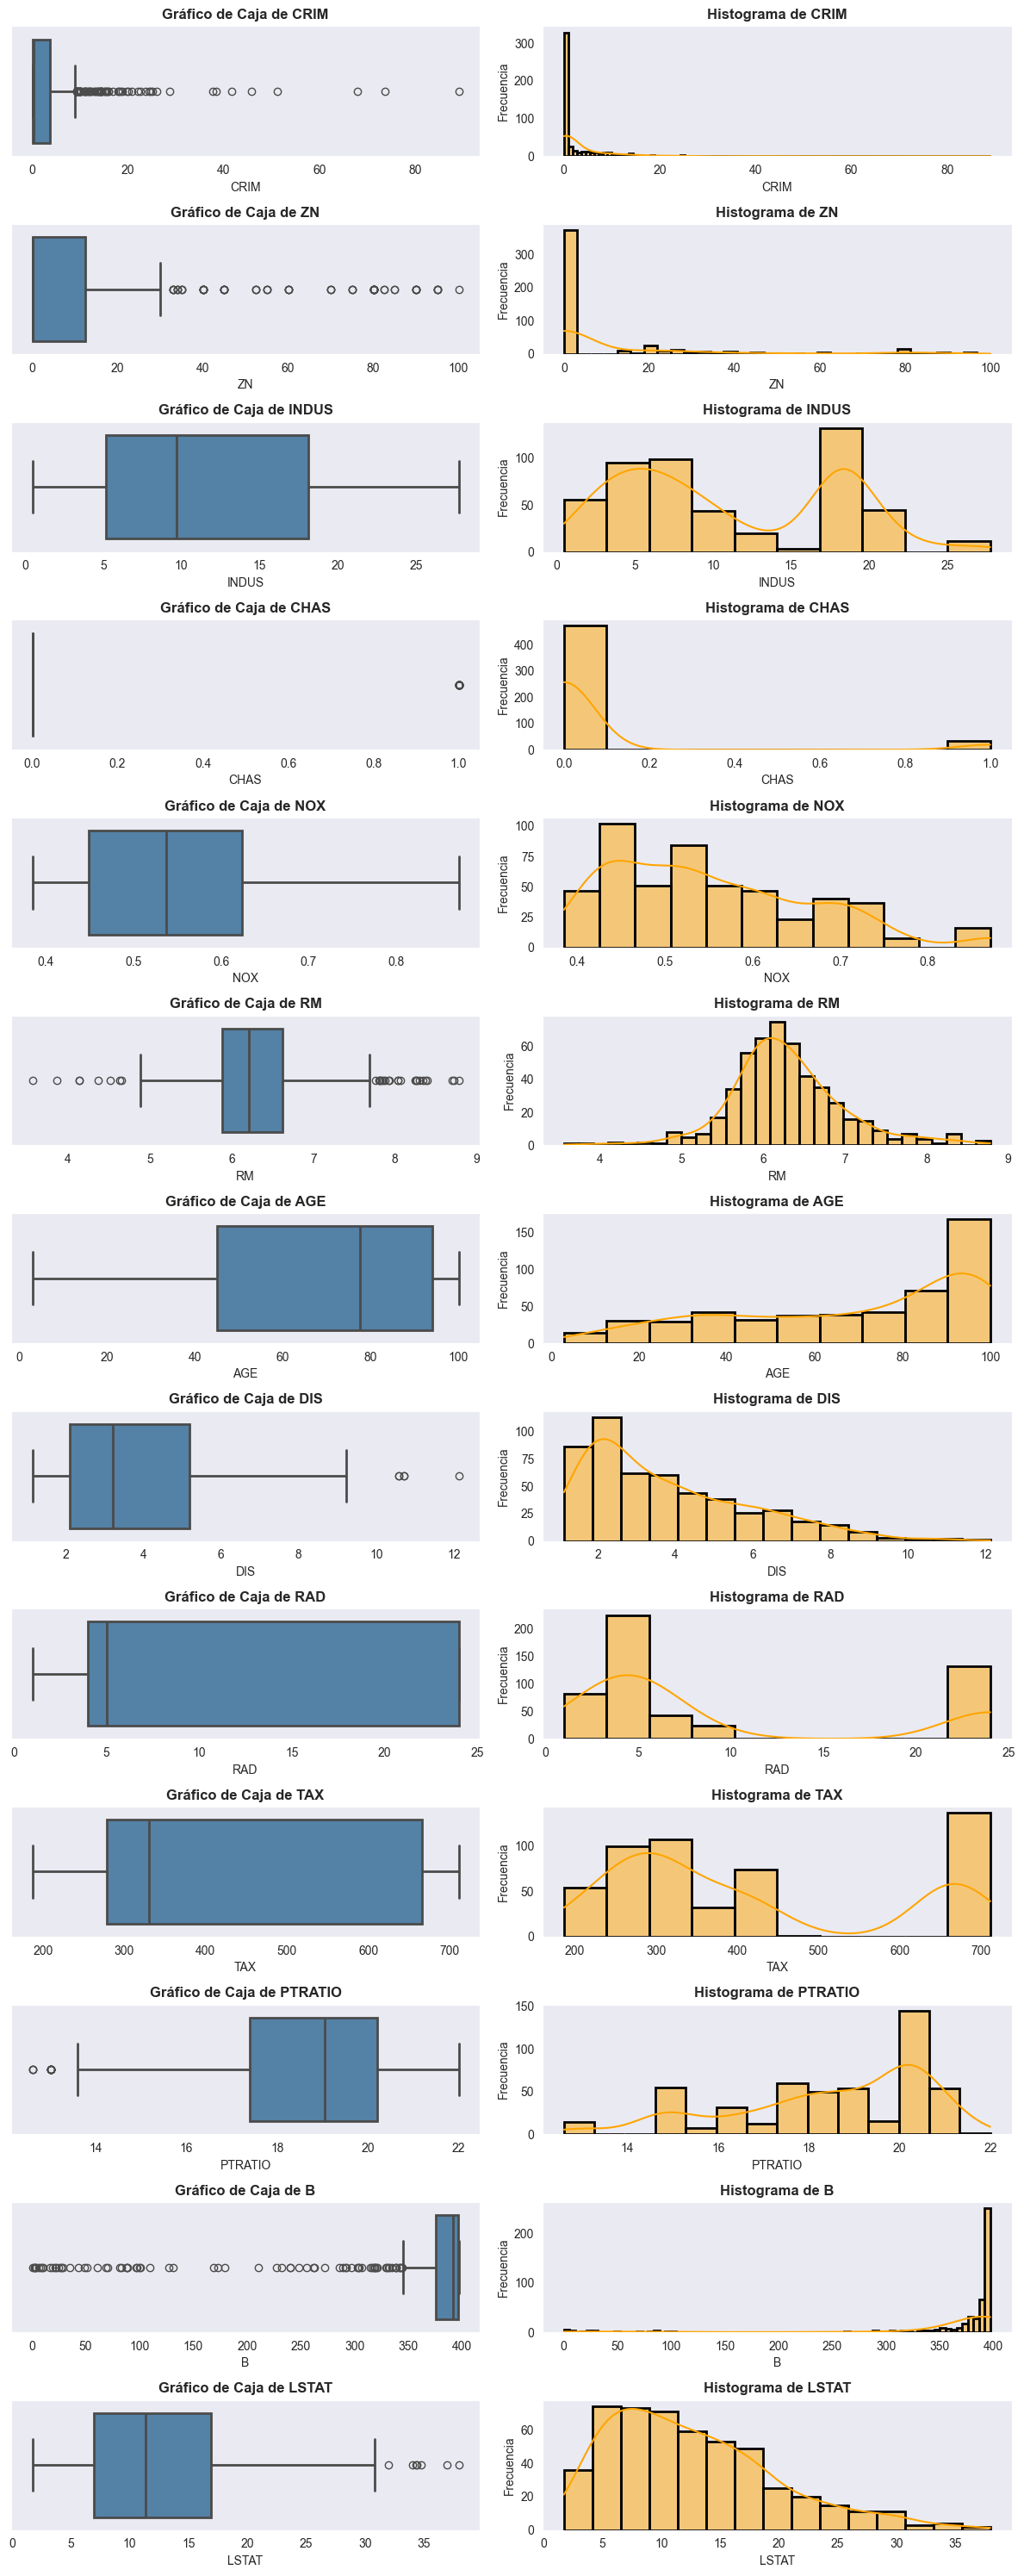

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = df.columns[:-1]

fig, axes = plt.subplots(len(cols), 2, figsize=(12, 30))
sns.set_style("dark")

for i, col in enumerate(cols):

    sns.boxplot(x=df[col], ax=axes[i, 0], color="steelblue", linewidth=2)
    axes[i, 0].set_title(f"Gráfico de Caja de {col}", fontweight="bold")

    sns.histplot(df[col], kde=True, ax=axes[i, 1], color="orange", linewidth=2, edgecolor="black")
    axes[i, 1].set_title(f"Histograma de {col}", fontweight="bold")
    axes[i, 1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

Ya que el árbol de decisión es un modelo no paramétrico, los supuestos de normalidad no tienen impacto alguno en el desempeño del modelo. Sin embargo, las variables con outliers potencialmente problemáticos son: LSTAT, B, RM, CHAS, ZN y CRIM.

#### **3. Preprocesamiento**

Para facilitar el aprendizaje del modelo, se empleará la winsorización para reducir el impacto de los outliers, sin eliminarlos, en las columnas recién mencionadas.

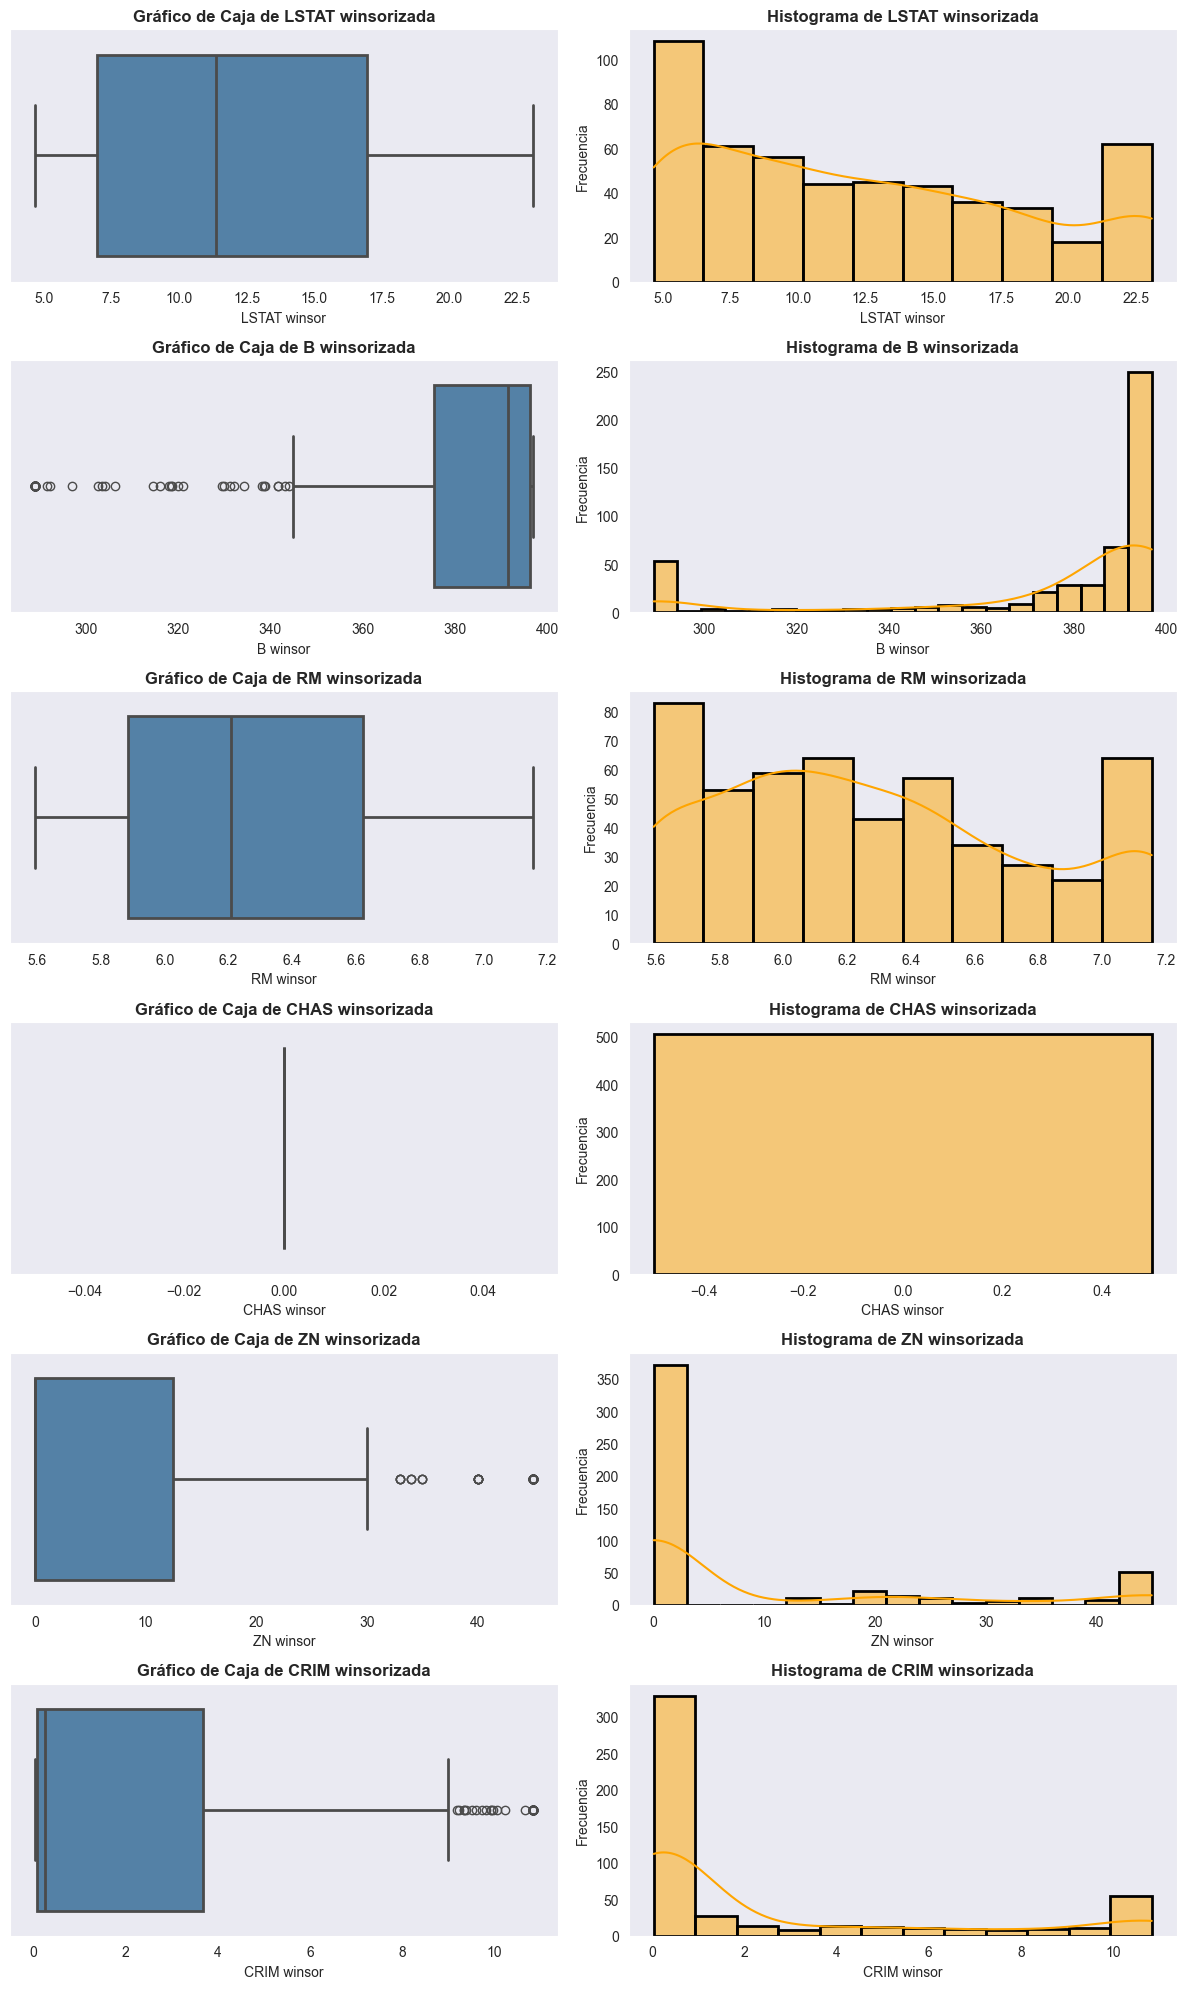

In [32]:
from scipy.stats.mstats import winsorize

win_cols = ['LSTAT', 'B', 'RM', 'CHAS', 'ZN' ,'CRIM']

for col in win_cols:
    df[f'{col} winsor'] = winsorize(df[col], limits=(0.1, 0.1))

fig, axes = plt.subplots(len(win_cols), 2, figsize=(12, 20))

for i, col in enumerate(win_cols):

    sns.boxplot(x=df[f'{col} winsor'], ax=axes[i, 0], color="steelblue", linewidth=2)
    axes[i, 0].set_title(f"Gráfico de Caja de {col} winsorizada", fontweight="bold")

    sns.histplot(df[f'{col} winsor'], kde=True, ax=axes[i, 1], color="orange", linewidth=2, edgecolor="black")
    axes[i, 1].set_title(f"Histograma de {col} winsorizada", fontweight="bold")
    axes[i, 1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

Se ha aplicado con éxito la winsorización. Ahora, los valores extremos no tendrán un impacto brusco en el modelo.

In [33]:
df.drop(columns=win_cols, inplace=True) #Se eliminan las columnas antes de la winsorización

#### **4. División de Conjuntos**

In [34]:
from sklearn.model_selection import train_test_split

Y = df["MEDV"]
X = df.drop(columns=['MEDV'])

#Se usa un 20% de los datos para prueba. Random_state asegura la reproducibilidad de los resultados
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Para propósitos prácticos, se utilizará el 20% de los datos para propósitos de prueba y el resto para el entrenamiento del árbol de decisión.

#### **5. Entrenamiento**

In [35]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

arbol = DecisionTreeRegressor(criterion='absolute_error', max_depth=4)
arbol.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=4)

#### **6. Optimización**

In [36]:
arbol3 = DecisionTreeRegressor(criterion='absolute_error', max_depth=3)
arbol3.fit(X_train, Y_train)

arbol5 = DecisionTreeRegressor(criterion='absolute_error', max_depth=5)
arbol5.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=5)

Se experimentará con profundidad máxima de 3 y de 5.

#### **7. Evaluación**

In [37]:
from sklearn.metrics import mean_absolute_error

Y_pred, Y_pred3, Y_pred5 = arbol.predict(X_test), arbol3.predict(X_test), arbol5.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
mae3 = mean_absolute_error(Y_test, Y_pred3)
mae5 = mean_absolute_error(Y_test, Y_pred5)

print(f"MAE: {mae:.3f}")
print(f"MAE (max_depth = 3): {mae3:.3f}")
print(f"MAE (max_depth = 5): {mae5:.3f}")

MAE: 2.766
MAE (max_depth = 3): 3.074
MAE (max_depth = 5): 3.186


El árbol más preciso resultó ser el de profundidad 4. Al tener profundidad 5 hay un aumento en MAE, lo que puede ser una señal de que se puede caer en sobreajuste a partir de esa profundidad.

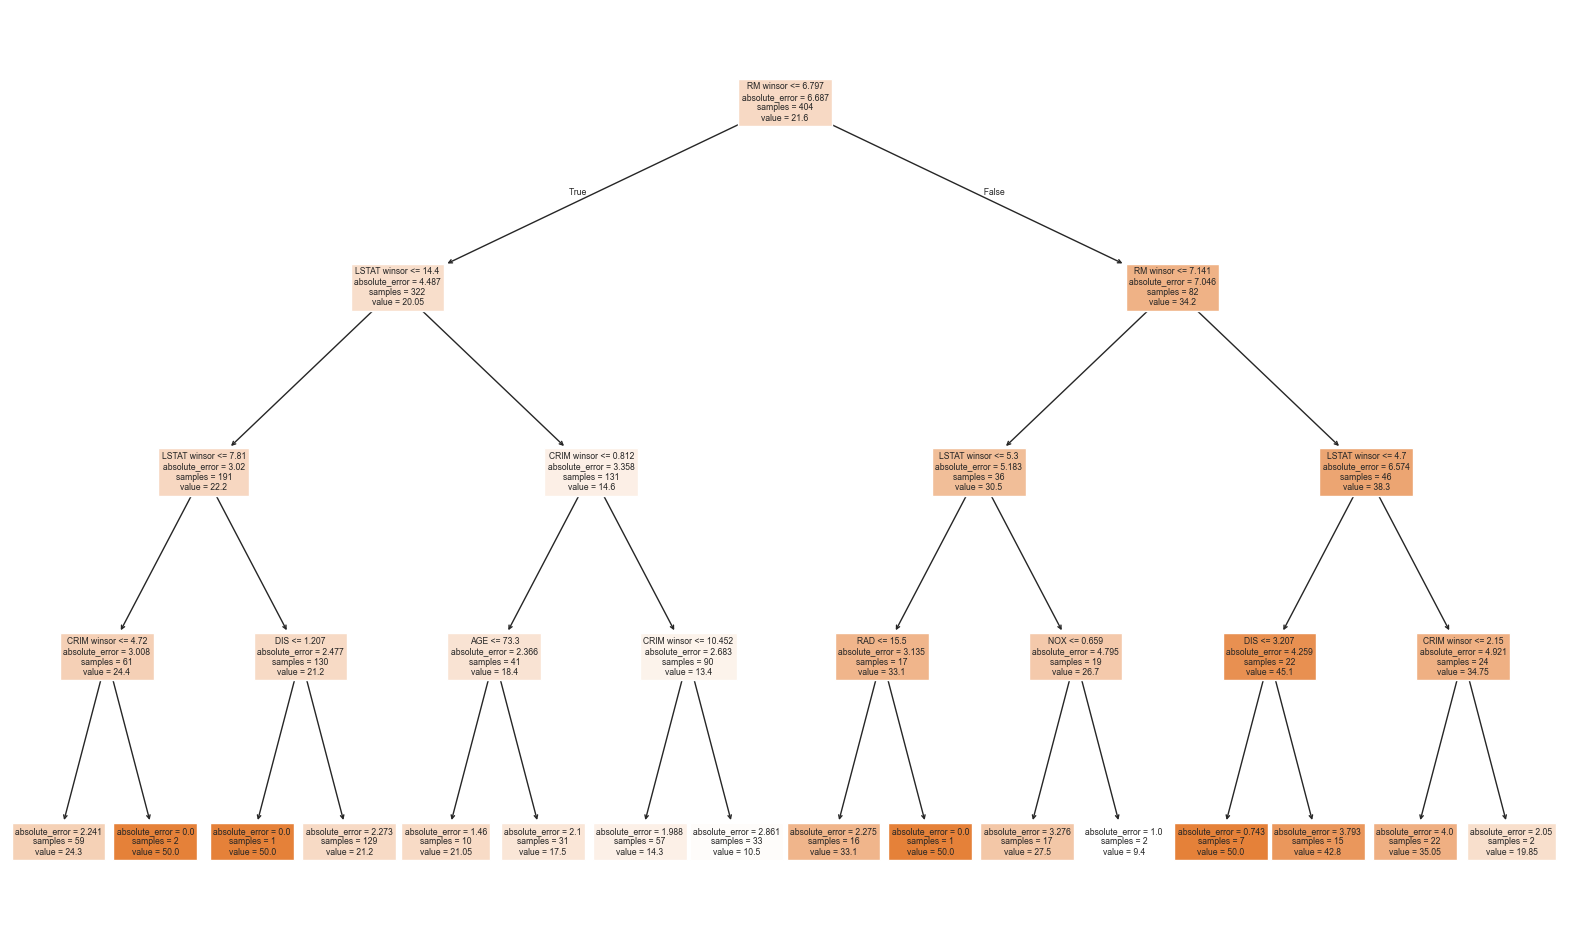

In [38]:
plt.figure(figsize=(20,12))
plot_tree(arbol, filled=True, feature_names=X.columns)
plt.show()

Arriba se ilustra el árbol de decisión con profunidad de 4, el cual tuvo la mayor precisión.